<a href="https://colab.research.google.com/github/einfy-75/go_by/blob/main/thanthwechat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

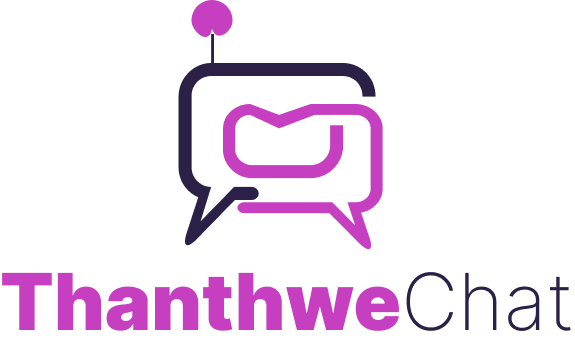

Mental Health Chatbot by finetuning Mistral 7B Model

**installation of packages **

In [3]:
!pip install -q -U torch=='2.0.0'
!pip install -q -U accelerate=='0.25.0' peft=='0.7.1' bitsandbytes=='0.41.3.post2' transformers=='4.36.1' trl=='0.7.4'
!pip install --upgrade pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 66.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 79.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [4]:
!pip install pandas

In [5]:
!pip install wandb --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.5/257.5 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.0 MB/s eta 0:00:00


In [7]:
import os
import warnings
import pandas as pd

import wandb
import torch
import transformers
import bitsandbytes
from huggingface_hub import login
from datasets import Dataset
from datasets import load_dataset
from peft import LoraConfig, PeftConfig, prepare_model_for_kbit_training, get_peft_model
from trl import SFTTrainer
from transformers import (AutoModelForCausalLM,
                         AutoTokenizer,
                         BitsAndBytesConfig,
                         TrainingArguments,
                         pipeline,
                         logging,
                         TrainerCallback)

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                            confusion_matrix,
                            classification_report)

In [8]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.environ['TOKENIZERS_PARALLELISM'] = "false"

In [9]:

warnings.filterwarnings("ignore")

In [10]:
dataset = load_dataset("Amod/mental_health_counseling_conversations")

Generating train split: 0 examples [00:00, ? examples/s]

In [11]:
df = pd.DataFrame(dataset['train'])

In [12]:
print(df.head())

                                             Context  \
0  I'm going through some things with my feelings...   
1  I'm going through some things with my feelings...   
2  I'm going through some things with my feelings...   
3  I'm going through some things with my feelings...   
4  I'm going through some things with my feelings...   

                                            Response  
0  If everyone thinks you're worthless, then mayb...  
1  Hello, and thank you for your question and see...  
2  First thing I'd suggest is getting the sleep y...  
3  Therapy is essential for those that are feelin...  
4  I first want to let you know that you are not ...  


In [13]:
df.shape

(3512, 2)

In [14]:
df.Context[13], df.Response[13]

("I'm going through some things with my feelings and myself. I barely sleep and I do nothing but think about how I'm worthless and how I shouldn't be here.\n   I've never tried or contemplated suicide. I've always wanted to fix my issues, but I never get around to it.\n   How can I change my feeling of being worthless to everyone?",
 "I'm glad you are interested in changing your feelings of worthlessness. Visiting your doctor is a great first step to address your lack of sleep. First, you want to make sure that you are physically healthy and that there isn't a physical condition causing your problem with sleep.\xa0Changing your feelings is something that is difficult to do, especially on your own. Make sure that you have someone you can trust and you can talk to about how you feel. This can be a friend or a family member. If you find that there isn't anyone you would feel comfortable talking to about this issue, find a therapist close to you who can help.\xa0One activity that people ha

In [15]:
def generate_prompt(datapoint):
    return f"""
            The conversation between a Human and an AI Mental Health Chatbot named ThanthweChat.
            [INST] You are a mental health expert. Your task is to generate an appropriate response based on the conversation given in square brackets.
            The tone of your answer should be warm and kind.
            [{datapoint['Context']}][/INST]

            {datapoint['Response']}""".strip()

def generate_test_prompt(datapoint):
    return f"""
            The conversation between a Human and an AI Mental Health Chatbot named ThanthweChat.
            [INST] You are a mental health expert. Your task is to generate an appropriate response based on the conversation given in square brackets.
            The tone of your answer should be warm and kind.
            [{datapoint['Context']}][/INST]""".strip()


In [16]:
X_train, X_eval = train_test_split(df, test_size=0.2, random_state=42)
X_train.shape, X_eval.shape

((2809, 2), (703, 2))

In [17]:
X_train = pd.DataFrame(X_train.apply(generate_prompt, axis=1), columns=['text'])
X_eval = pd.DataFrame(X_eval.apply(generate_test_prompt, axis=1),columns=['text'])
X_train.head()

,text
2659,The conversation between a Human and an AI Men...
1057,The conversation between a Human and an AI Men...
2111,The conversation between a Human and an AI Men...
1565,The conversation between a Human and an AI Men...
631,The conversation between a Human and an AI Men...


In [18]:
train_data = Dataset.from_pandas(X_train)
eval_data = Dataset.from_pandas(X_eval)

In [19]:
train_data[0]

{'text': "The conversation between a Human and an AI Mental Health Chatbot named ThanthweChat.\n            [INST] You are a mental health expert. Your task is to generate an appropriate response based on the conversation given in square brackets.\n            The tone of your answer should be warm and kind.\n            [We don't have sex a lot. I cheat when we argue. I don't kiss or have unprotected sex with them. It's a one time thing, and I never see them twice.][/INST]\n            \n            \nHello, and thank you for your question. The question about\r\nwhether or not to cheat is based on personal values that can only be answered\r\nby you. However, here are a few things to consider and questions to ask\r\nyourself to help you find your answer:\n1.\xa0\xa0\xa0\xa0\r\nDo you feel like you are violating your own\r\nvalues or morals? This is important, because we all have different values and\r\nmorals surrounding sex, love, and monogamy. If you value monogamous\r\nrelationships

In [20]:
model_name = "mistralai/Mistral-7B-Instruct-v0.2"
model_hub_id = "GRMenon/mental-health-mistral-7b-instructv0.2-finetuned-V2"

compute_dtype = getattr(torch, "float16")

bnb_config = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_use_double_quant = False,
    bnb_4bit_quant_type = 'nf4',
    bnb_4bit_compute_dtype = compute_dtype
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map='auto',
    quantization_config=bnb_config,
)

model.config.use_cache = False
model.config.pretraining_tp = 1

tokenizer = AutoTokenizer.from_pretrained(model_name,
                                          trust_remote_code=True,
                                          add_eos_token=True,
                                         )
tokenizer.pad_token = tokenizer.eos_token

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

In [21]:
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [23]:
import json

# Load the uploaded JSON file
with open('secrets.json') as f:
    secrets = json.load(f)

# Access the Hugging Face API key
hf_key = secrets["huggingface"]

In [24]:
class PeftSavingCallback(TrainerCallback):
    def on_save(self, args, state, control, **kwargs):
        checkpoint_path = os.path.join(args.output_dir, f"checkpoint-{state.global_step}")
        kwargs["model"].save_pretrained(checkpoint_path)

        if "pytorch_model.bin" in os.listdir(checkpoint_path):
            os.remove(os.path.join(checkpoint_path, "pytorch_model.bin"))


In [25]:
callbacks = [PeftSavingCallback]

In [26]:
project = "mental-health-chatbot-finetuned-v2"
base_model_name = "mistral-7b-instruct"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

In [27]:
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=16,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "v_proj"]
)

training_arguments = TrainingArguments(
    output_dir=output_dir,
    logging_dir = "logs",
    per_device_train_batch_size=8,
    num_train_epochs=3,
    gradient_accumulation_steps=1,
    optim="paged_adamw_32bit",
    save_strategy='epoch',
    logging_steps=25,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=True,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio = 0.05,
    group_by_length=True,
    lr_scheduler_type="cosine",
    report_to="wandb",
    evaluation_strategy="epoch",
    do_eval=True,
    run_name = run_name,
    push_to_hub = True,
    hub_model_id = model_hub_id,
    hub_token=hf_key,
    hub_strategy="checkpoint",
    disable_tqdm=False
)

trainer = SFTTrainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=eval_data,
    peft_config=peft_config,
    dataset_text_field="text",
    tokenizer=tokenizer,
    args=training_arguments,
    callbacks=callbacks,
    packing=False,
    max_seq_length=512)

Map:   0%|          | 0/2809 [00:00<?, ? examples/s]

Map:   0%|          | 0/703 [00:00<?, ? examples/s]

In [28]:
model = get_peft_model(model, peft_config)

In [29]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
torch.cuda.empty_cache()

In [30]:
import json

# Load the uploaded JSON file
with open('secretsx.json') as f:
    secrets = json.load(f)

# Access the Hugging Face API key
wb_key = secrets["wandb"]

In [31]:
wandb.login(key=wb_key)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
trainer.train()

wandb: Currently logged in as: patrickcravings. Use `wandb login --relogin` to force relogin


You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss


In [1]:
trainer.push_to_hub()
wandb.finish()
model.config.use_cache = True

NameError: name 'trainer' is not defined